In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import scale

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px
# Graphics in retina format 
%config InlineBackend.figure_format = 'retina' 

import warnings
warnings.filterwarnings("ignore")

## The Stock Market Data

In [2]:
Smarket = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)
Smarket.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Let's divide this dataset into train and test sets. In doing so, the data before 2005 is considered for the train set and the data from 2005 onward for the test set. That is

In [3]:
X_train, y_train = Smarket.loc[(Smarket.index < '2005'), ['Lag1','Lag2']], Smarket.loc[(Smarket.index < '2005'), ['Direction']]
X_test, y_test = Smarket.loc[(Smarket.index >= '2005'), ['Lag1','Lag2']], Smarket.loc[(Smarket.index >= '2005'), ['Direction']]

## K-Nearest Neighbors

Given a positive integer $K$ and a test observation $x_0$, the KNN classifier first identifies the $K$ points in the training data that are closest to $x_0$, represented by $\mathcal{N}_0$.

It then estimates the conditional probability for class $j$ as the fraction of points in $\mathcal{N}_0$ whose response values equal $j$:
$$\mbox{Pr}(Y = j~|~X = x_0)~=~\frac{1}{K}\sum_{i \in \mathcal{N}_0} I \left(y_i = j \right).$$

Finally, KNN applies Bayes rule and classifies the test observation $x_0$ to
the class with the largest probability.

Here we use [**sklearn KNeighbors Classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

In [4]:
KKN = KNeighborsClassifier(n_neighbors=3)
# Predictions
y_pred = KKN.fit(X_train, y_train).predict(X_test)

* **Classification Report:**

In [5]:
Class_Names = list(np.sort(Smarket.Direction.unique()))
Results = pd.DataFrame(classification_report(y_test, y_pred,
                                             target_names=Class_Names, output_dict=True)).T
display(Results.round(2))

,precision,recall,f1-score,support
Down,0.47,0.43,0.45,111.00
Up,0.58,0.61,0.59,141.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.52,0.52,0.52,252.00
weighted avg,0.53,0.53,0.53,252.00


* **Confusion Matrix**:

A confusion matrix is a table that is often used to describe the performance of a classification model (classifier) on a set of test data, **X_test** and **y_test**.

In [6]:
confusion_matrix(y_test, y_pred)

array([[48, 63],
       [55, 86]], dtype=int64)

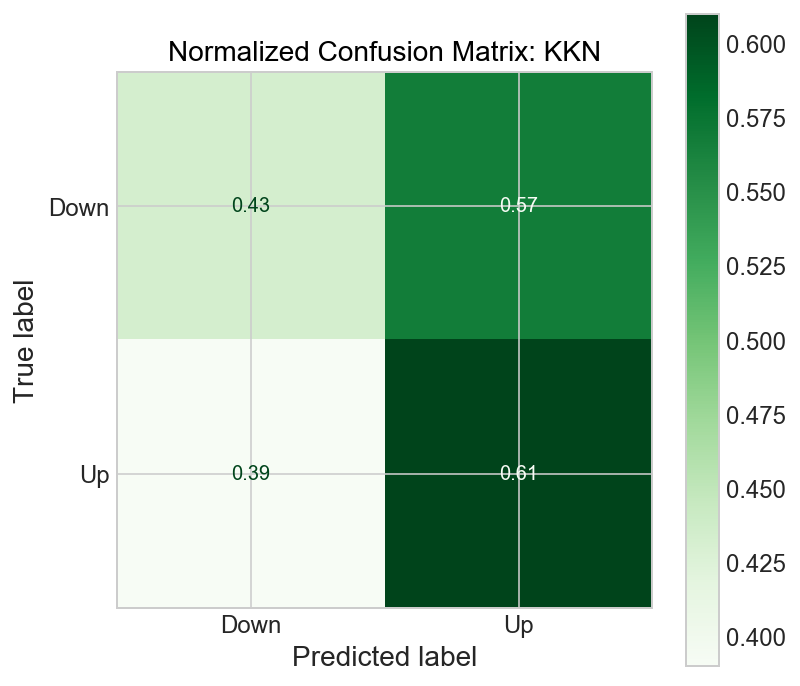

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names,
                      cmap= "Greens", normalize= 'true', ax = ax)
_ = ax.set_title('Normalized Confusion Matrix: KKN')

***

## Caravan Insurance Data

In [8]:
Caravan = pd.read_csv('Data/Caravan.csv')
X = Caravan.drop('Purchase', axis=1).astype('float64')
y = Caravan['Purchase']
# Scaling the data using scikit-learn scale
X = scale(X)

Class_Names = list(np.sort(Caravan.Purchase.unique()))

We now split the observations into a test set, containing the first $1,000$ observations, and a training set, containing the remaining observations.

In [9]:
N = int(1e3)
X_train, X_test = X[N:,:], X[:N,:]
y_train, y_test = y[N:], y[:N]
del N

### KNN with K = 1

Confusion Matrix


,No,Yes
No,873,68
Yes,50,9


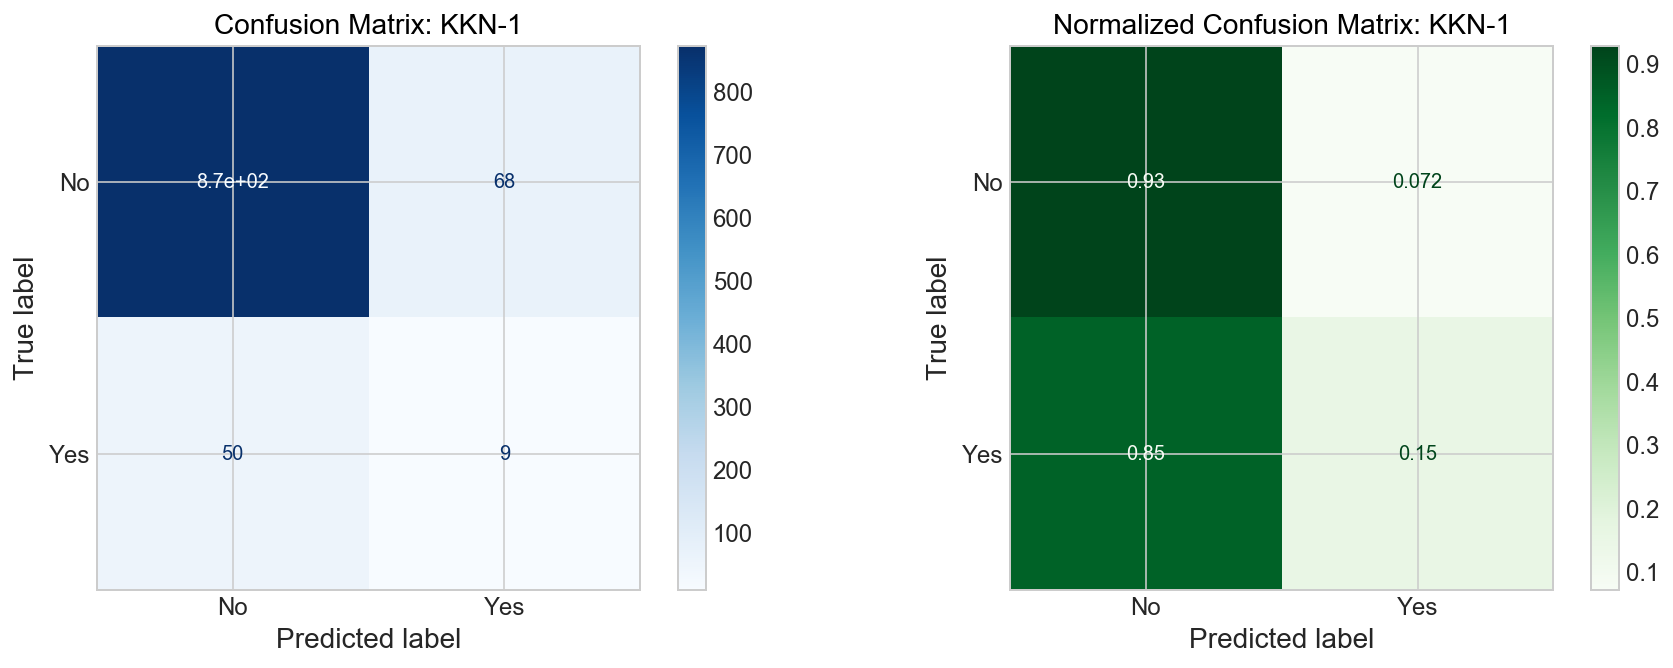

In [10]:
n_neighbors = 1
KKN = KNeighborsClassifier(n_neighbors, weights = 'uniform')
_ = KKN.fit(X_train, y_train)
y_pred = KKN.predict(X_test)
score = KKN.score(X_test, y_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Confusion Matrix'  + Style.RESET_ALL)
display(pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = Class_Names, columns = Class_Names))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Blues", normalize= None, ax = ax[0])
_ = ax[0].set_title('Confusion Matrix: KKN-%i' % n_neighbors)

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Greens", normalize= 'true', ax = ax[1])
_ = ax[1].set_title('Normalized Confusion Matrix: KKN-%i' % n_neighbors)

### KNN with K = 3

Confusion Matrix


,No,Yes
No,921,20
Yes,54,5


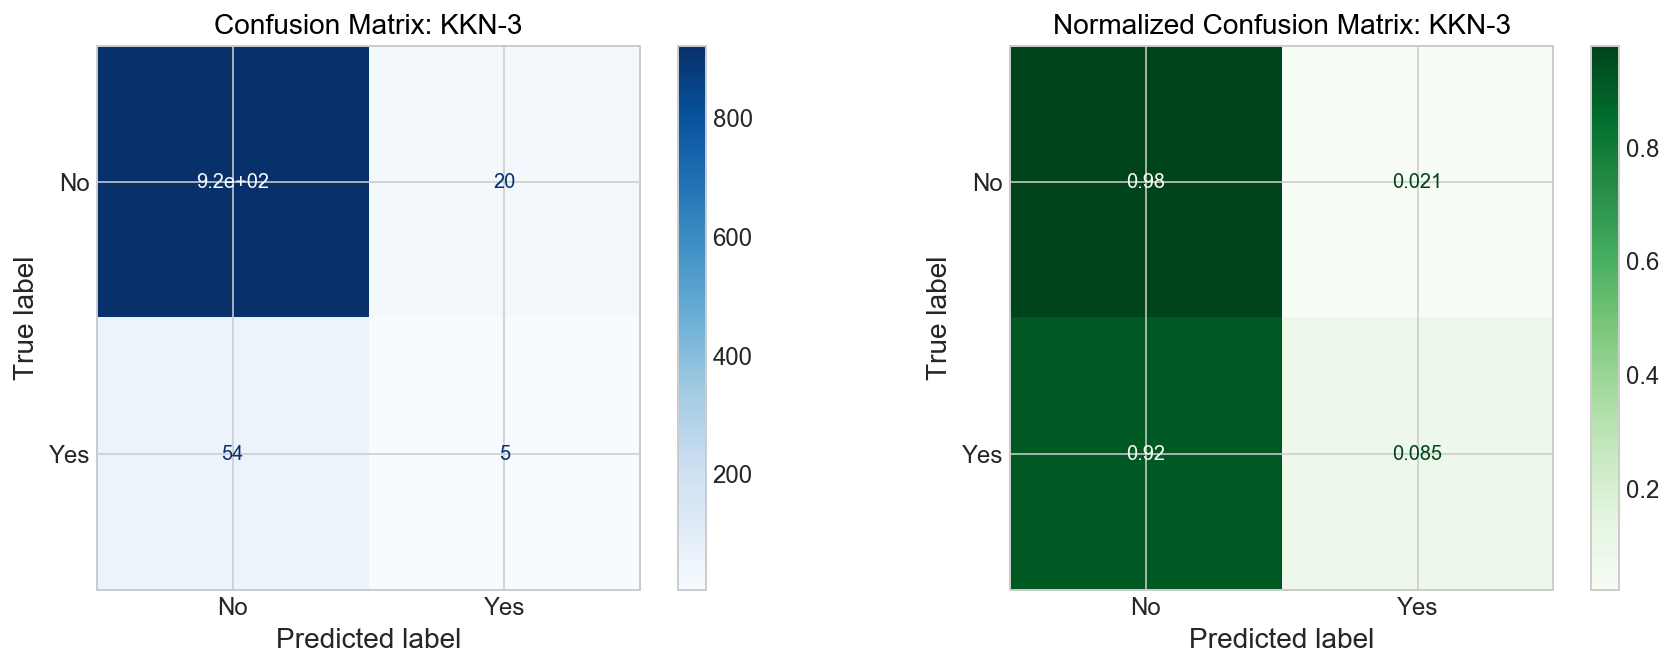

In [11]:
n_neighbors = 3
KKN = KNeighborsClassifier(n_neighbors, weights = 'uniform')
_ = KKN.fit(X_train, y_train)
y_pred = KKN.predict(X_test)
score = KKN.score(X_test, y_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Confusion Matrix'  + Style.RESET_ALL)
display(pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = Class_Names, columns = Class_Names))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Blues", normalize= None, ax = ax[0])
_ = ax[0].set_title('Confusion Matrix: KKN-%i' % n_neighbors)

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Greens", normalize= 'true', ax = ax[1])
_ = ax[1].set_title('Normalized Confusion Matrix: KKN-%i' % n_neighbors)

### KNN with K = 5

Confusion Matrix


,No,Yes
No,930,11
Yes,55,4


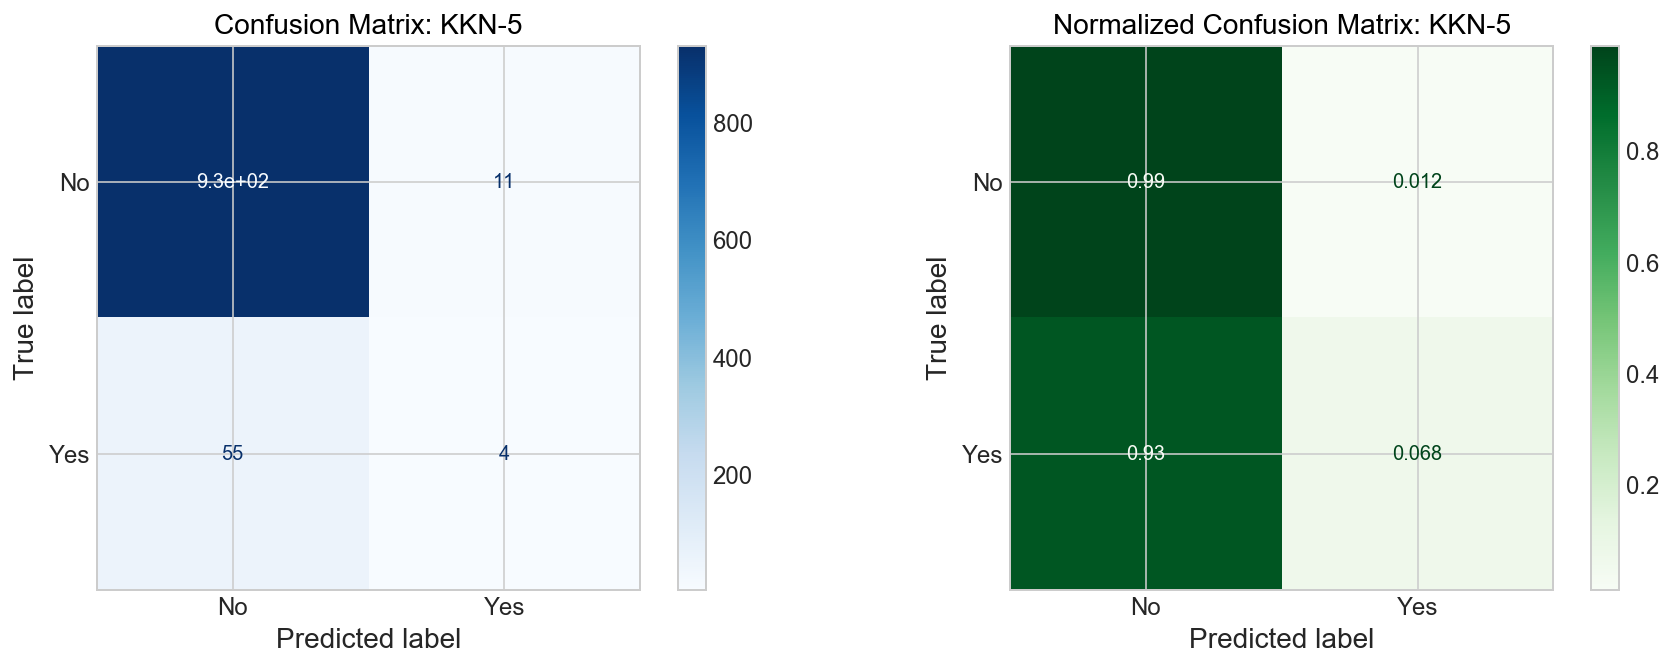

In [12]:
n_neighbors = 5
KKN = KNeighborsClassifier(n_neighbors, weights = 'uniform')
_ = KKN.fit(X_train, y_train)
y_pred = KKN.predict(X_test)
score = KKN.score(X_test, y_test)
print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Confusion Matrix'  + Style.RESET_ALL)
display(pd.DataFrame(data = confusion_matrix(y_test, y_pred), index = Class_Names, columns = Class_Names))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Blues", normalize= None, ax = ax[0])
_ = ax[0].set_title('Confusion Matrix: KKN-%i' % n_neighbors)

_ = plot_confusion_matrix(KKN, X_test, y_test, display_labels= Class_Names, cmap= "Greens", normalize= 'true', ax = ax[1])
_ = ax[1].set_title('Normalized Confusion Matrix: KKN-%i' % n_neighbors)

***